<a href="https://colab.research.google.com/github/sofianna-e/DeliveriesEKPA/blob/main/PPS_Ransomware_Excersice.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [5]:
#εισαγωγή βιβλιοθηκών - πακέτων
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import make_pipeline
from sklearn.covariance import EllipticEnvelope
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, classification_report, confusion_matrix
from sklearn.svm import OneClassSVM
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

ValueError: numpy.dtype size changed, may indicate binary incompatibility. Expected 96 from C header, got 88 from PyObject

In [4]:
#εισαγωγή του συνόλου δεδομένων
dataset=pd.read_csv("https://media.githubusercontent.com/media/kdemertzis/EKPA/main/Data/Ransomware.csv",sep='|')

NameError: name 'pd' is not defined

In [5]:
#eξερεύνηση συνόλου δεδομένων
dataset

,Name,md5,Machine,SizeOfOptionalHeader,Characteristics,MajorLinkerVersion,MinorLinkerVersion,SizeOfCode,SizeOfInitializedData,SizeOfUninitializedData,...,ResourcesNb,ResourcesMeanEntropy,ResourcesMinEntropy,ResourcesMaxEntropy,ResourcesMeanSize,ResourcesMinSize,ResourcesMaxSize,LoadConfigurationSize,VersionInformationSize,legitimate
0,memtest.exe,631ea355665f28d4707448e442fbf5b8,332,224,258,9,0,361984,115712,0,...,4,3.262823,2.568844,3.537939,8797.000000,216,18032,0,16,1
1,ose.exe,9d10f99a6712e28f8acd5641e3a7ea6b,332,224,3330,9,0,130560,19968,0,...,2,4.250461,3.420744,5.080177,837.000000,518,1156,72,18,1
2,setup.exe,4d92f518527353c0db88a70fddcfd390,332,224,3330,9,0,517120,621568,0,...,11,4.426324,2.846449,5.271813,31102.272727,104,270376,72,18,1
3,DW20.EXE,a41e524f8d45f0074fd07805ff0c9b12,332,224,258,9,0,585728,369152,0,...,10,4.364291,2.669314,6.400720,1457.000000,90,4264,72,18,1
4,dwtrig20.exe,c87e561258f2f8650cef999bf643a731,332,224,258,9,0,294912,247296,0,...,2,4.306100,3.421598,5.190603,1074.500000,849,1300,72,18,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
138042,VirusShare_8e292b418568d6e7b87f2a32aee7074b,8e292b418568d6e7b87f2a32aee7074b,332,224,258,11,0,205824,223744,0,...,7,4.122736,1.370260,7.677091,14900.714286,16,81654,72,0,0
138043,VirusShare_260d9e2258aed4c8a3bbd703ec895822,260d9e2258aed4c8a3bbd703ec895822,332,224,33167,2,25,37888,185344,0,...,26,3.377663,2.031619,5.050074,6905.846154,44,67624,0,15,0
138044,VirusShare_8d088a51b7d225c9f5d11d239791ec3f,8d088a51b7d225c9f5d11d239791ec3f,332,224,258,10,0,118272,380416,0,...,22,6.825406,2.617026,7.990487,14981.909091,48,22648,72,14,0
138045,VirusShare_4286dccf67ca220fe67635388229a9f3,4286dccf67ca220fe67635388229a9f3,332,224,33166,2,25,49152,16896,0,...,10,3.421627,2.060964,4.739744,601.600000,16,2216,0,0,0


In [6]:
#περιγραφικά στατιστικά συνόλου δεδομένων
dataset.describe()

,Machine,SizeOfOptionalHeader,Characteristics,MajorLinkerVersion,MinorLinkerVersion,SizeOfCode,SizeOfInitializedData,SizeOfUninitializedData,AddressOfEntryPoint,BaseOfCode,...,ResourcesNb,ResourcesMeanEntropy,ResourcesMinEntropy,ResourcesMaxEntropy,ResourcesMeanSize,ResourcesMinSize,ResourcesMaxSize,LoadConfigurationSize,VersionInformationSize,legitimate
count,138047.000000,138047.000000,138047.000000,138047.000000,138047.000000,1.380470e+05,1.380470e+05,1.380470e+05,1.380470e+05,1.380470e+05,...,138047.000000,138047.000000,138047.000000,138047.000000,1.380470e+05,1.380470e+05,1.380470e+05,1.380470e+05,138047.000000,138047.000000
mean,4259.069274,225.845632,4444.145994,8.619774,3.819286,2.425956e+05,4.504867e+05,1.009525e+05,1.719561e+05,5.779845e+04,...,22.050700,4.000127,2.434541,5.521610,5.545093e+04,1.818082e+04,2.465903e+05,4.656750e+05,12.363115,0.299340
std,10880.347245,5.121399,8186.782524,4.088757,11.862675,5.754485e+06,2.101599e+07,1.635288e+07,3.430553e+06,5.527658e+06,...,136.494244,1.112981,0.815577,1.597403,7.799163e+06,6.502369e+06,2.124860e+07,2.608987e+07,6.798878,0.457971
min,332.000000,224.000000,2.000000,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000
25%,332.000000,224.000000,258.000000,8.000000,0.000000,3.020800e+04,2.457600e+04,0.000000e+00,1.272100e+04,4.096000e+03,...,5.000000,3.458505,2.178748,4.828706,9.560000e+02,4.800000e+01,2.216000e+03,0.000000e+00,13.000000,0.000000
50%,332.000000,224.000000,258.000000,9.000000,0.000000,1.136640e+05,2.631680e+05,0.000000e+00,5.288300e+04,4.096000e+03,...,6.000000,3.729824,2.458492,5.317552,2.708154e+03,4.800000e+01,9.640000e+03,7.200000e+01,15.000000,0.000000
75%,332.000000,224.000000,8226.000000,10.000000,0.000000,1.203200e+05,3.850240e+05,0.000000e+00,6.157800e+04,4.096000e+03,...,13.000000,4.233051,2.696833,6.502239,6.558429e+03,1.320000e+02,2.378000e+04,7.200000e+01,16.000000,1.000000
max,34404.000000,352.000000,49551.000000,255.000000,255.000000,1.818587e+09,4.294966e+09,4.294941e+09,1.074484e+09,2.028711e+09,...,7694.000000,7.999723,7.999723,8.000000,2.415919e+09,2.415919e+09,4.294903e+09,4.294967e+09,26.000000,1.000000


In [7]:
# ανακάτεμα δεδομένων
dataset = dataset.sample(frac=1).reset_index(drop=True)
dataset.head()

,Name,md5,Machine,SizeOfOptionalHeader,Characteristics,MajorLinkerVersion,MinorLinkerVersion,SizeOfCode,SizeOfInitializedData,SizeOfUninitializedData,...,ResourcesNb,ResourcesMeanEntropy,ResourcesMinEntropy,ResourcesMaxEntropy,ResourcesMeanSize,ResourcesMinSize,ResourcesMaxSize,LoadConfigurationSize,VersionInformationSize,legitimate
0,CORPerfMonExt.dll,dc3078ba1b58562416c843582a42284c,332,224,8450,10,0,88576,38400,0,...,1,3.521336,3.521336,3.521336,1080.000000,1080,1080,72,18,1
1,VirusShare_d75a5d84597d53532ba7b4460e60c0ce,d75a5d84597d53532ba7b4460e60c0ce,332,224,258,10,0,119808,382976,0,...,20,6.630328,2.458492,7.992976,16634.850000,48,29056,72,15,0
2,GROOVE.EXE,71eee466e9415ac872101b600cd93b89,34404,240,34,9,0,28542976,22939136,0,...,197,4.665553,2.612776,7.976695,19310.736041,160,157180,0,18,1
3,VirusShare_d32245ec53b7c7aeefcb3e8c3a516a40,d32245ec53b7c7aeefcb3e8c3a516a40,332,224,258,10,0,118784,382464,0,...,16,6.342496,2.458492,7.993070,20840.000000,48,40724,72,14,0
4,wuapp.exe,7cfcc5210e226aa85f2a21098fa01f29,34404,240,34,9,0,32256,8192,0,...,2,4.340906,3.552805,5.129006,753.000000,566,940,0,16,1


In [8]:
#tαξινόμηση δεδομένων με βάση το εάν είναι νόμιμο ή κακόβουλο λογισμικό
#0 legit, 1 ransomware
dataset.groupby(dataset['legitimate']).size()

,0
legitimate,
0,96724
1,41323


([<matplotlib.patches.Wedge at 0x7bc2fdb98e90>,
 [Text(0.6484073680146373, 0.888576324861478, 'Malware'),
  Text(-0.6484076610757229, -0.8885761110103684, 'Legitimate')],
 [Text(0.3536767461898021, 0.4846779953789879, '30%'),
  Text(-0.35367690604130336, -0.48467787873292817, '70%')])

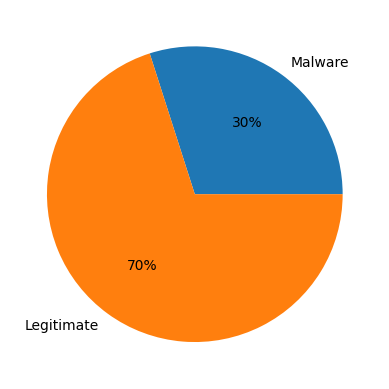

In [9]:
#γραφική απεικόνιση δεδομένων με βάση το εάν είναι νόμιμο ή κακόβουλο λογισμικό#
#0 legit, 1 ransomware
type_classify=['Malware', 'Legitimate']
count_classify=[41323,96724]
plt.pie(count_classify, labels=type_classify, autopct='%0.f%%')

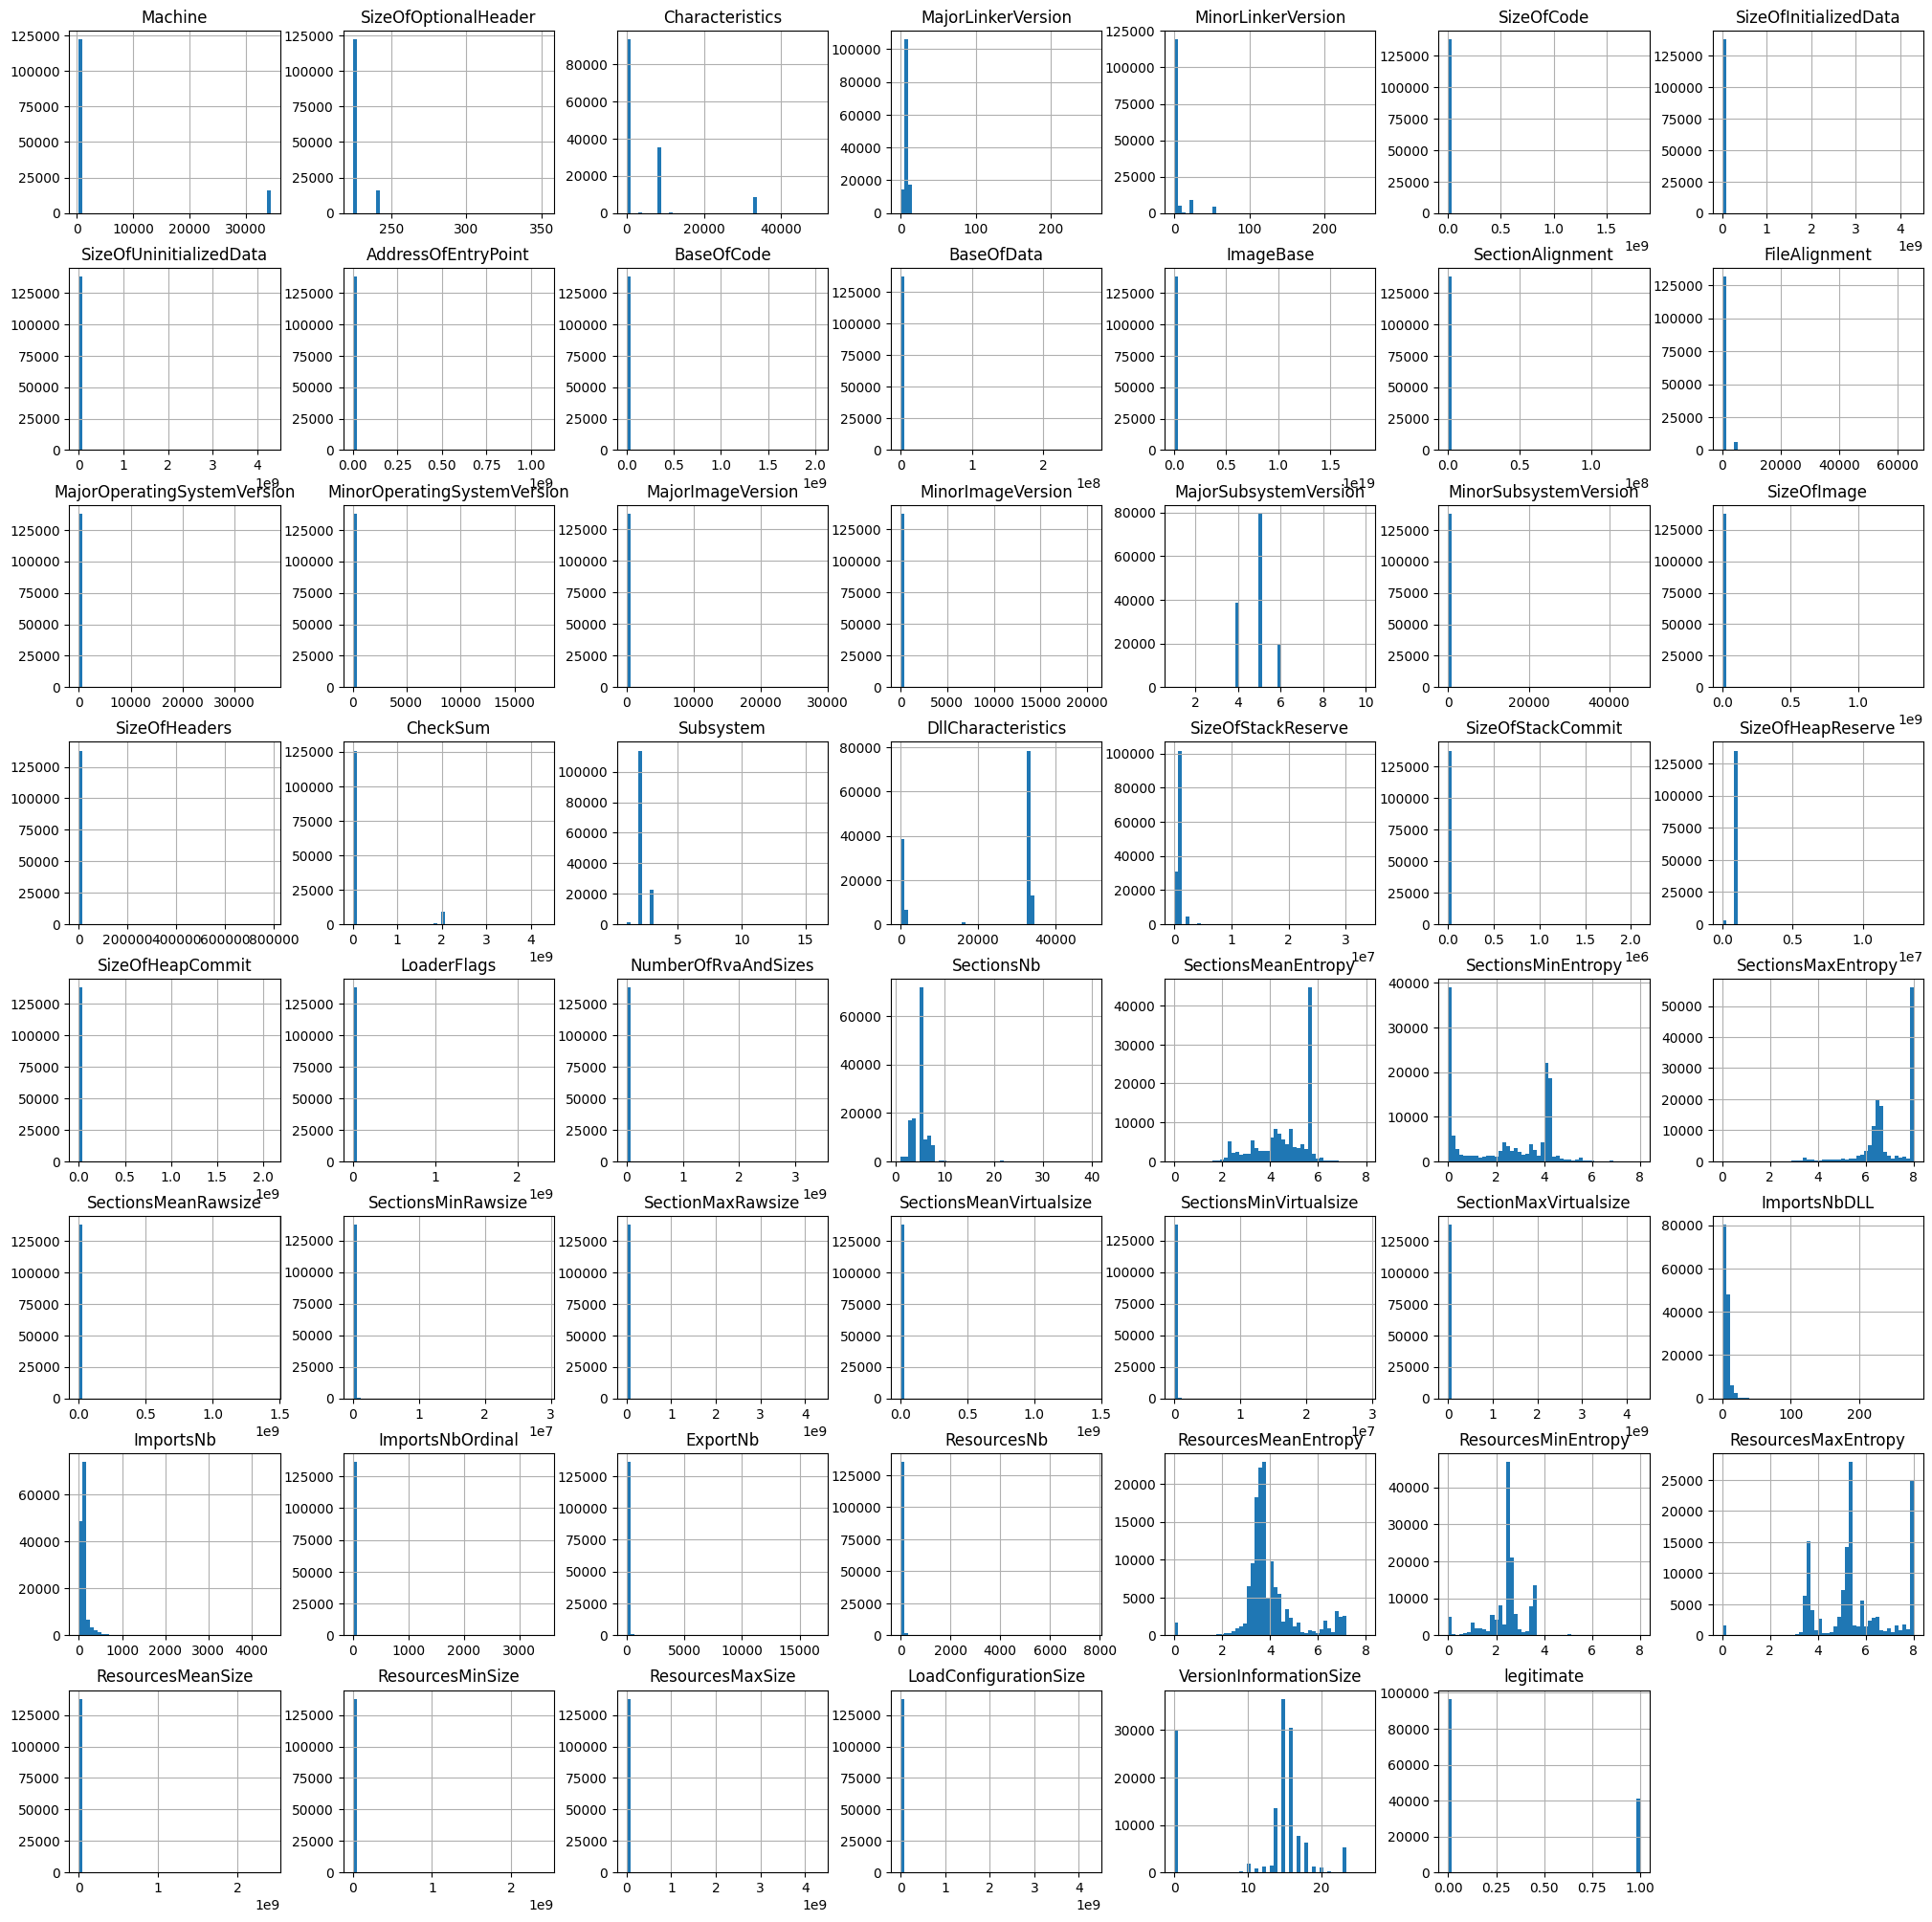

In [10]:
#οπτικοποίηση της κατανομής των δεδομένων
dataset.hist(bins = 50,figsize = (25,25))
plt.show()

In [11]:
#πίνακας συσχέτισης χαρακτηριστικών του συνόλου δεδομένων
plt.figure(figsize=(15,13))
sns.heatmap(dataset.corr())
plt.show()

ValueError: could not convert string to float: 'CORPerfMonExt.dll'

<Figure size 1500x1300 with 0 Axes>

In [12]:
#έλεγχος κενών τιμών στα δεδομένα
dataset.isnull().sum()

,0
Name,0
md5,0
Machine,0
SizeOfOptionalHeader,0
Characteristics,0
MajorLinkerVersion,0
MinorLinkerVersion,0
SizeOfCode,0
SizeOfInitializedData,0
SizeOfUninitializedData,0


In [13]:
# Ορισμός X και y
X = dataset.drop('legitimate', axis=1)
y = dataset['legitimate']

In [14]:
# Χειρισμός τιμών που λείπουν με στρατηγική "συμπλήρωση με σταθερή τιμή"
imputer = SimpleImputer(strategy='constant', fill_value='unknown')
X_imputed = pd.DataFrame(imputer.fit_transform(X), columns=X.columns)
X_imputed

,Name,md5,Machine,SizeOfOptionalHeader,Characteristics,MajorLinkerVersion,MinorLinkerVersion,SizeOfCode,SizeOfInitializedData,SizeOfUninitializedData,...,ExportNb,ResourcesNb,ResourcesMeanEntropy,ResourcesMinEntropy,ResourcesMaxEntropy,ResourcesMeanSize,ResourcesMinSize,ResourcesMaxSize,LoadConfigurationSize,VersionInformationSize
0,CORPerfMonExt.dll,dc3078ba1b58562416c843582a42284c,332,224,8450,10,0,88576,38400,0,...,5,1,3.521336,3.521336,3.521336,1080.0,1080,1080,72,18
1,VirusShare_d75a5d84597d53532ba7b4460e60c0ce,d75a5d84597d53532ba7b4460e60c0ce,332,224,258,10,0,119808,382976,0,...,0,20,6.630328,2.458492,7.992976,16634.85,48,29056,72,15
2,GROOVE.EXE,71eee466e9415ac872101b600cd93b89,34404,240,34,9,0,28542976,22939136,0,...,46,197,4.665553,2.612776,7.976695,19310.736041,160,157180,0,18
3,VirusShare_d32245ec53b7c7aeefcb3e8c3a516a40,d32245ec53b7c7aeefcb3e8c3a516a40,332,224,258,10,0,118784,382464,0,...,0,16,6.342496,2.458492,7.99307,20840.0,48,40724,72,14
4,wuapp.exe,7cfcc5210e226aa85f2a21098fa01f29,34404,240,34,9,0,32256,8192,0,...,0,2,4.340906,3.552805,5.129006,753.0,566,940,0,16
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
138042,comctl32.dll,791206e0343ad8e61826e063f2e4c885,332,224,8450,9,0,1352192,328192,0,...,214,94,3.514599,1.055383,6.359715,2772.223404,20,27688,72,16
138043,VirusShare_51e6af770b268e4fffda194d775bdb38,51e6af770b268e4fffda194d775bdb38,332,224,258,11,0,113664,682496,0,...,0,7,4.453368,2.623078,7.967002,80992.857143,62,534528,0,0
138044,wshbth.dll,46c55935fa730144449c884a472827e0,332,224,8462,7,10,95744,11264,0,...,17,1,3.585054,3.585054,3.585054,912.0,912,912,72,16
138045,VirusShare_d7bb36c812ccdf9478d2db88fe53bf6d,d7bb36c812ccdf9478d2db88fe53bf6d,332,224,33167,2,25,37888,24064,0,...,0,12,3.941722,2.458492,6.059971,1600.833333,44,9640,0,0


In [15]:
# Ορίζουμε ένα LabelEncoder για κάθε στήλη με συμβολοσειρές
label_encoders = {}
for column in X_imputed.select_dtypes(include='object').columns:
    label_encoders[column] = LabelEncoder()
    X_imputed[column] = label_encoders[column].fit_transform(X_imputed[column])

In [16]:
# Δημιουργία του OneClassSVM με προεπιλεγμένες ρυθμίσεις για τον εντοπισμό ακραίων τιμών
outlier_detector = OneClassSVM(nu=0.05)
outliers = outlier_detector.fit_predict(X_imputed)

In [17]:
# Επαναφορά των αρχικών τιμών συμβολοσειρών αν χρειαστεί
for column in X_imputed.select_dtypes(include='object').columns:
    X_imputed[column] = label_encoders[column].inverse_transform(X_imputed[column])

In [18]:
# Εκτύπωση των ακραίων τιμών
print("Ακραίες Τιμές:\n", outliers)

Ακραίες Τιμές:
 [1 1 1 ... 1 1 1]


In [19]:
# Δημιουργία νέου συνόλου δεδομένων μετά την αφαίρεση των ακραίων τιμών
clean_data = pd.DataFrame(X_imputed[outliers != -1])
clean_data['legitimate'] = y[outliers != -1]

In [20]:
# Αναφορά του νέου συνόλου ανά κλάση
remaining_instances_report = clean_data['legitimate'].value_counts()
print("Αναφορά υπολοίπων περιπτώσεων ανά κατηγορία:\n", remaining_instances_report)

Αναφορά υπολοίπων περιπτώσεων ανά κατηγορία:
 legitimate
0    94378
1    36767
Name: count, dtype: int64


In [21]:
# Εκτύπωση καθαρού συνόλου
clean_data

,Name,md5,Machine,SizeOfOptionalHeader,Characteristics,MajorLinkerVersion,MinorLinkerVersion,SizeOfCode,SizeOfInitializedData,SizeOfUninitializedData,...,ResourcesNb,ResourcesMeanEntropy,ResourcesMinEntropy,ResourcesMaxEntropy,ResourcesMeanSize,ResourcesMinSize,ResourcesMaxSize,LoadConfigurationSize,VersionInformationSize,legitimate
0,798,118438,0,0,70,10,0,244,112,0,...,1,17727,10952,4747,4845,734,390,1,12,1
1,84743,114788,0,0,11,10,0,308,815,0,...,20,42449,2649,22287,13706,44,2982,1,9,0
2,1410,45849,2,2,6,9,0,3793,3163,0,...,190,38505,3154,21714,13921,131,4668,0,12,1
3,82292,111620,0,0,11,10,0,306,814,0,...,16,42305,2649,22295,14052,44,3334,1,8,0
4,107392,52521,2,2,6,9,0,119,44,0,...,2,36027,14145,15865,3338,422,301,0,10,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
138042,102444,50125,0,0,70,9,0,2206,698,0,...,94,17245,403,18898,9220,20,2942,1,10,1
138043,24356,32936,0,0,11,11,0,296,1319,0,...,7,37061,3206,21530,15381,55,5392,0,0,0
138044,107359,28438,0,0,73,7,10,261,51,0,...,1,22956,17016,11628,4156,660,280,1,10,1
138045,85001,115109,0,0,94,2,24,132,81,0,...,12,28900,2649,18297,6837,41,2027,0,0,0


In [22]:
pip install -U ppscore

  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.2/5.2 MB 54.4 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for ppscore: filename=ppscore-1.3.0-py2.py3-none-any.whl size=13166 sha256=47bc291a5f7ed9f2a7f2a791e89aa1f5d866496485236cc2577a6f8ff91f8b4a
  Stored in directory: /root/.cache/pip/wheels/30/1c/06/b724ffb08ed69cd209743b44137306245ebbf025fd9acacf0c
  Created wheel for pandas: filename=pandas-1.5.3-cp312-cp312-linux_x86_64.whl size=41460942 sha256=cf01aab96bf586165c04bfa7d2683c26dec9581b5abbbaf00d1f9c4e3a1a8657
  Stored in directory: /root/.cache/pip/wheels/fb/83/18/8e7307aa1185c5498c5490e4d9c8a1732d9f1056e86c3491c6
Successfully built ppscore pandas
  Attempting uninstall: pandas
    Found existing installation: pandas 2.2.2
    Uninstalling pandas-2.2.2:
      Successfully uninstalled pandas-2.2.2
ERROR: pip's dependency 

In [ ]:
import numpy as np
import ppscore as pps

df = pd.DataFrame()
df["x"] = np.random.uniform(-2, 2, 1_000_000)
df["error"] = np.random.uniform(-0.5, 0.5, 1_000_000)
df["y"] = df["x"] * df["x"] + df["error"]

In [ ]:
pps.score(df, "x", "y")

In [ ]:
pps.predictors(df, "y")

In [ ]:
pps.matrix(df)

In [ ]:
import seaborn as sns
predictors_df = pps.predictors(df, y="y")
sns.barplot(data=predictors_df, x="x", y="ppscore")

In [ ]:
import seaborn as sns
matrix_df = pps.matrix(df)[['x', 'y', 'ppscore']].pivot(columns='x', index='y', values='ppscore')
sns.heatmap(matrix_df, vmin=0, vmax=1, cmap="Blues", linewidths=0.5, annot=True)